# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

качество предсказания;
скорость предсказания;
время обучения.

бибилиотеки

In [1]:
!pip install phik -q
!pip install catboost -q
!pip install category_encoders -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 687.8/687.8 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import phik

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

from category_encoders import BinaryEncoder

## Подготовка данных

In [3]:
from google.colab import files

# Загружаем сразу несколько файлов (можно выделить их при выборе)
uploaded = files.upload()

Saving autos.csv to autos.csv


In [4]:
pd.set_option('display.max_columns', None)

In [5]:
data = pd.read_csv('autos.csv')

In [6]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Приведем столбцы с датой к нужному формату.

In [8]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'])
data['DateCreated'] = pd.to_datetime(data['DateCreated'])
data['LastSeen'] = pd.to_datetime(data['LastSeen'])

In [9]:
data.describe()

,DateCrawled,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369,354369.0,354369.000000,354369
mean,2016-03-21 12:58:10.450648320,4416.656776,2004.234448,110.094337,128211.172535,5.714645,2016-03-20 19:12:07.753274112,0.0,50508.689087,2016-03-29 23:51:00.667456768
min,2016-03-05 14:06:22,0.000000,1000.000000,0.000000,5000.000000,0.000000,2014-03-10 00:00:00,0.0,1067.000000,2016-03-05 14:15:08
25%,2016-03-13 11:52:33,1050.000000,1999.000000,69.000000,125000.000000,3.000000,2016-03-13 00:00:00,0.0,30165.000000,2016-03-23 02:50:03
50%,2016-03-21 17:50:55,2700.000000,2003.000000,105.000000,150000.000000,6.000000,2016-03-21 00:00:00,0.0,49413.000000,2016-04-03 15:15:51
75%,2016-03-29 14:37:20,6400.000000,2008.000000,143.000000,150000.000000,9.000000,2016-03-29 00:00:00,0.0,71083.000000,2016-04-06 10:15:19
max,2016-04-07 14:36:58,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,2016-04-07 00:00:00,0.0,99998.000000,2016-04-07 14:58:51
std,NaN,4514.158514,90.227958,189.850405,37905.341530,3.726421,NaN,0.0,25783.096248,NaN


In [10]:
data = data.drop(['NumberOfPictures', 'PostalCode'], axis=1)

Удалили 2 столбца, которые нам не пригодятся.

Выведим пропуски в процентах.

In [11]:
def percentage_missing(df):
    total_cells = df.size
    missing_cells = df.isnull().sum().sum()
    percentage = (missing_cells / total_cells) * 100
    print(f"{percentage:.1f}% от всех ячеек содержат пропущенные значения.")
    for col in df.columns:
        missing_count = df[col].isnull().sum()
        missing_percent = (missing_count / len(df)) * 100
        print(f"Столбец '{col}': {missing_percent:.1f}% пропущенных значений")

In [12]:
percentage_missing(data)

3.6% от всех ячеек содержат пропущенные значения.
Столбец 'DateCrawled': 0.0% пропущенных значений
Столбец 'Price': 0.0% пропущенных значений
Столбец 'VehicleType': 10.6% пропущенных значений
Столбец 'RegistrationYear': 0.0% пропущенных значений
Столбец 'Gearbox': 5.6% пропущенных значений
Столбец 'Power': 0.0% пропущенных значений
Столбец 'Model': 5.6% пропущенных значений
Столбец 'Kilometer': 0.0% пропущенных значений
Столбец 'RegistrationMonth': 0.0% пропущенных значений
Столбец 'FuelType': 9.3% пропущенных значений
Столбец 'Brand': 0.0% пропущенных значений
Столбец 'Repaired': 20.1% пропущенных значений
Столбец 'DateCreated': 0.0% пропущенных значений
Столбец 'LastSeen': 0.0% пропущенных значений


Выводим все уникальные значения в категориальных столбцах.

In [13]:
def get_categorical_unique_values(df, df_name):

    # Выбираем только категориальные столбцы
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns

    # Фильтруем столбцы, исключая те, которые выглядят как даты
    date_like_columns = []
    for col in categorical_columns:
        # Проверяем, можно ли преобразовать столбец в дату. Если да - добавляем его в список "подозрительных"
        try:
            pd.to_datetime(df[col], errors='raise')  # errors='raise' вызывает исключение, если не получается
            date_like_columns.append(col)
        except (ValueError, TypeError):  # Если не получилось, значит это не дата-подобный столбец
            pass

    # Оставляем только столбцы, не похожие на даты
    categorical_columns = [col for col in categorical_columns if col not in date_like_columns]

    # Выводим название DataFrame
    print(f"Уникальные значения для категориальных столбцов в DataFrame '{df_name}' (исключая даты):")
    print('-' * 80)

    # Проходим по каждому категориальному столбцу и выводим уникальные значения
    for column in categorical_columns:
        print(f"Столбец '{column}':")
        print(df[column].unique())
        print('_' * 80)

In [14]:
get_categorical_unique_values(data, 'таблица')

Уникальные значения для категориальных столбцов в DataFrame 'таблица' (исключая даты):
--------------------------------------------------------------------------------
Столбец 'VehicleType':
[nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
________________________________________________________________________________
Столбец 'Gearbox':
['manual' 'auto' nan]
________________________________________________________________________________
Столбец 'Model':
['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' '

<ipython-input-13-4d532a00faad>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[col], errors='raise')  # errors='raise' вызывает исключение, если не получается
<ipython-input-13-4d532a00faad>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[col], errors='raise')  # errors='raise' вызывает исключение, если не получается
<ipython-input-13-4d532a00faad>:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.to_datetime(df[col], errors='raise')  # errors='raise' вызывает исключение, если не получается
<ipython-input-13-4d532a00faad>:11: User

Синонимы слова бензин обьеденим в petrol.

In [15]:
data.loc[data['FuelType']=='gasoline', 'FuelType']='petrol'

Удалим дубликаты.

In [16]:
data.duplicated().sum()

np.int64(5)

In [17]:
data = data.drop_duplicates().reset_index(drop=True)

In [18]:
def plot_numeric_distributions_with_boxplot(df):
    numeric_columns = df.select_dtypes(include=['number']).columns

    if len(numeric_columns) == 0:
        print("В DataFrame нет числовых столбцов.")
        return

    num_cols = len(numeric_columns)
    num_rows = num_cols  # Каждый столбец занимает свою строку

    fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))  # Создаем сетку графиков с 2 столбцами.

    if num_cols == 1:
        axes = axes.reshape(1, 2)
    else:
        axes = axes.reshape(num_rows, 2) # Гарантируем, что axes имеет правильную форму

    for i, col in enumerate(numeric_columns):
        # Гистограмма
        ax_hist = axes[i, 0]
        df[col].hist(ax=ax_hist)
        ax_hist.set_title(col + "(Histogram)")
        ax_hist.set_xlabel("Значение")
        ax_hist.set_ylabel("Частота")

        # Boxplot
        ax_box = axes[i, 1]
        sns.boxplot(x=df[col], ax=ax_box)
        ax_box.set_title(col + "(Boxplot)")
        ax_box.set_xlabel("Значение")

    plt.tight_layout()
    plt.show()

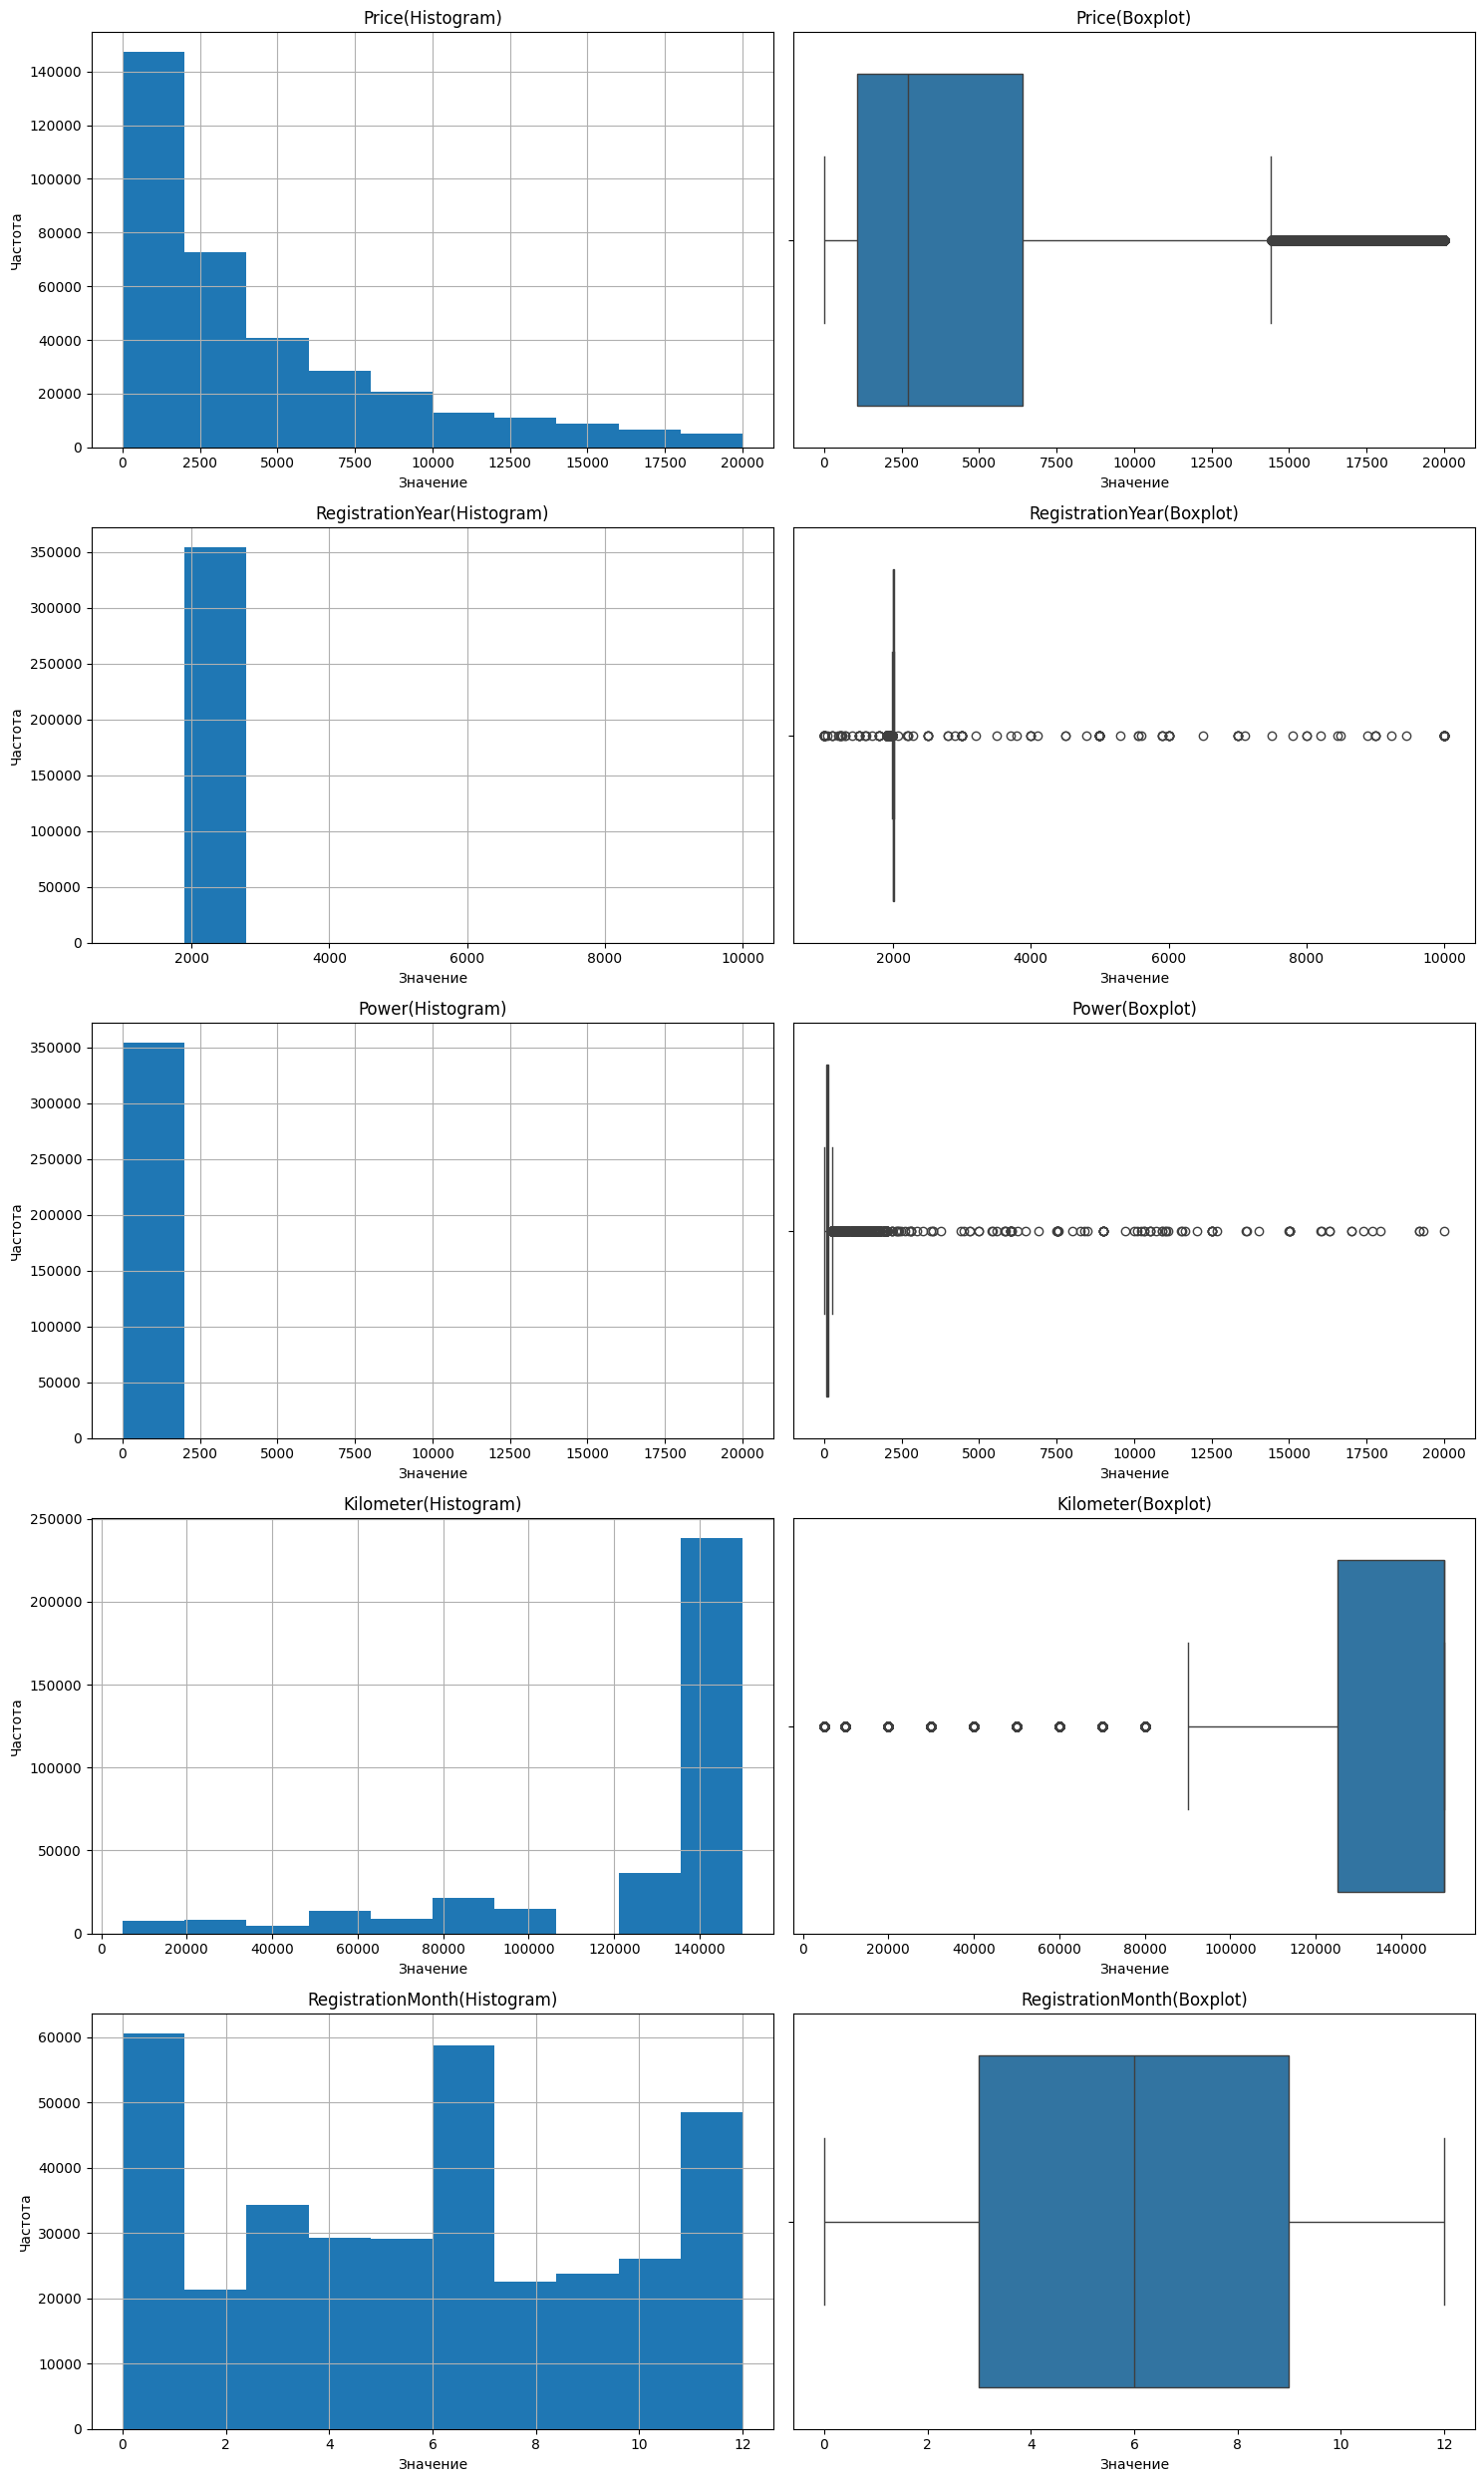

In [19]:
plot_numeric_distributions_with_boxplot(data)

Видим выбросы в цене, регистрации и мощности, удалим их.

In [20]:
data = data[(data['Price'] >= 10) &
            (data['RegistrationYear'] >= 1900) & (data['RegistrationYear'] <= 2016) &
            (data['Power'] <= 1000)]

In [21]:
print(data['DateCrawled'].max())
print(data['DateCrawled'].min())

2016-04-07 14:36:58
2016-03-05 14:06:22


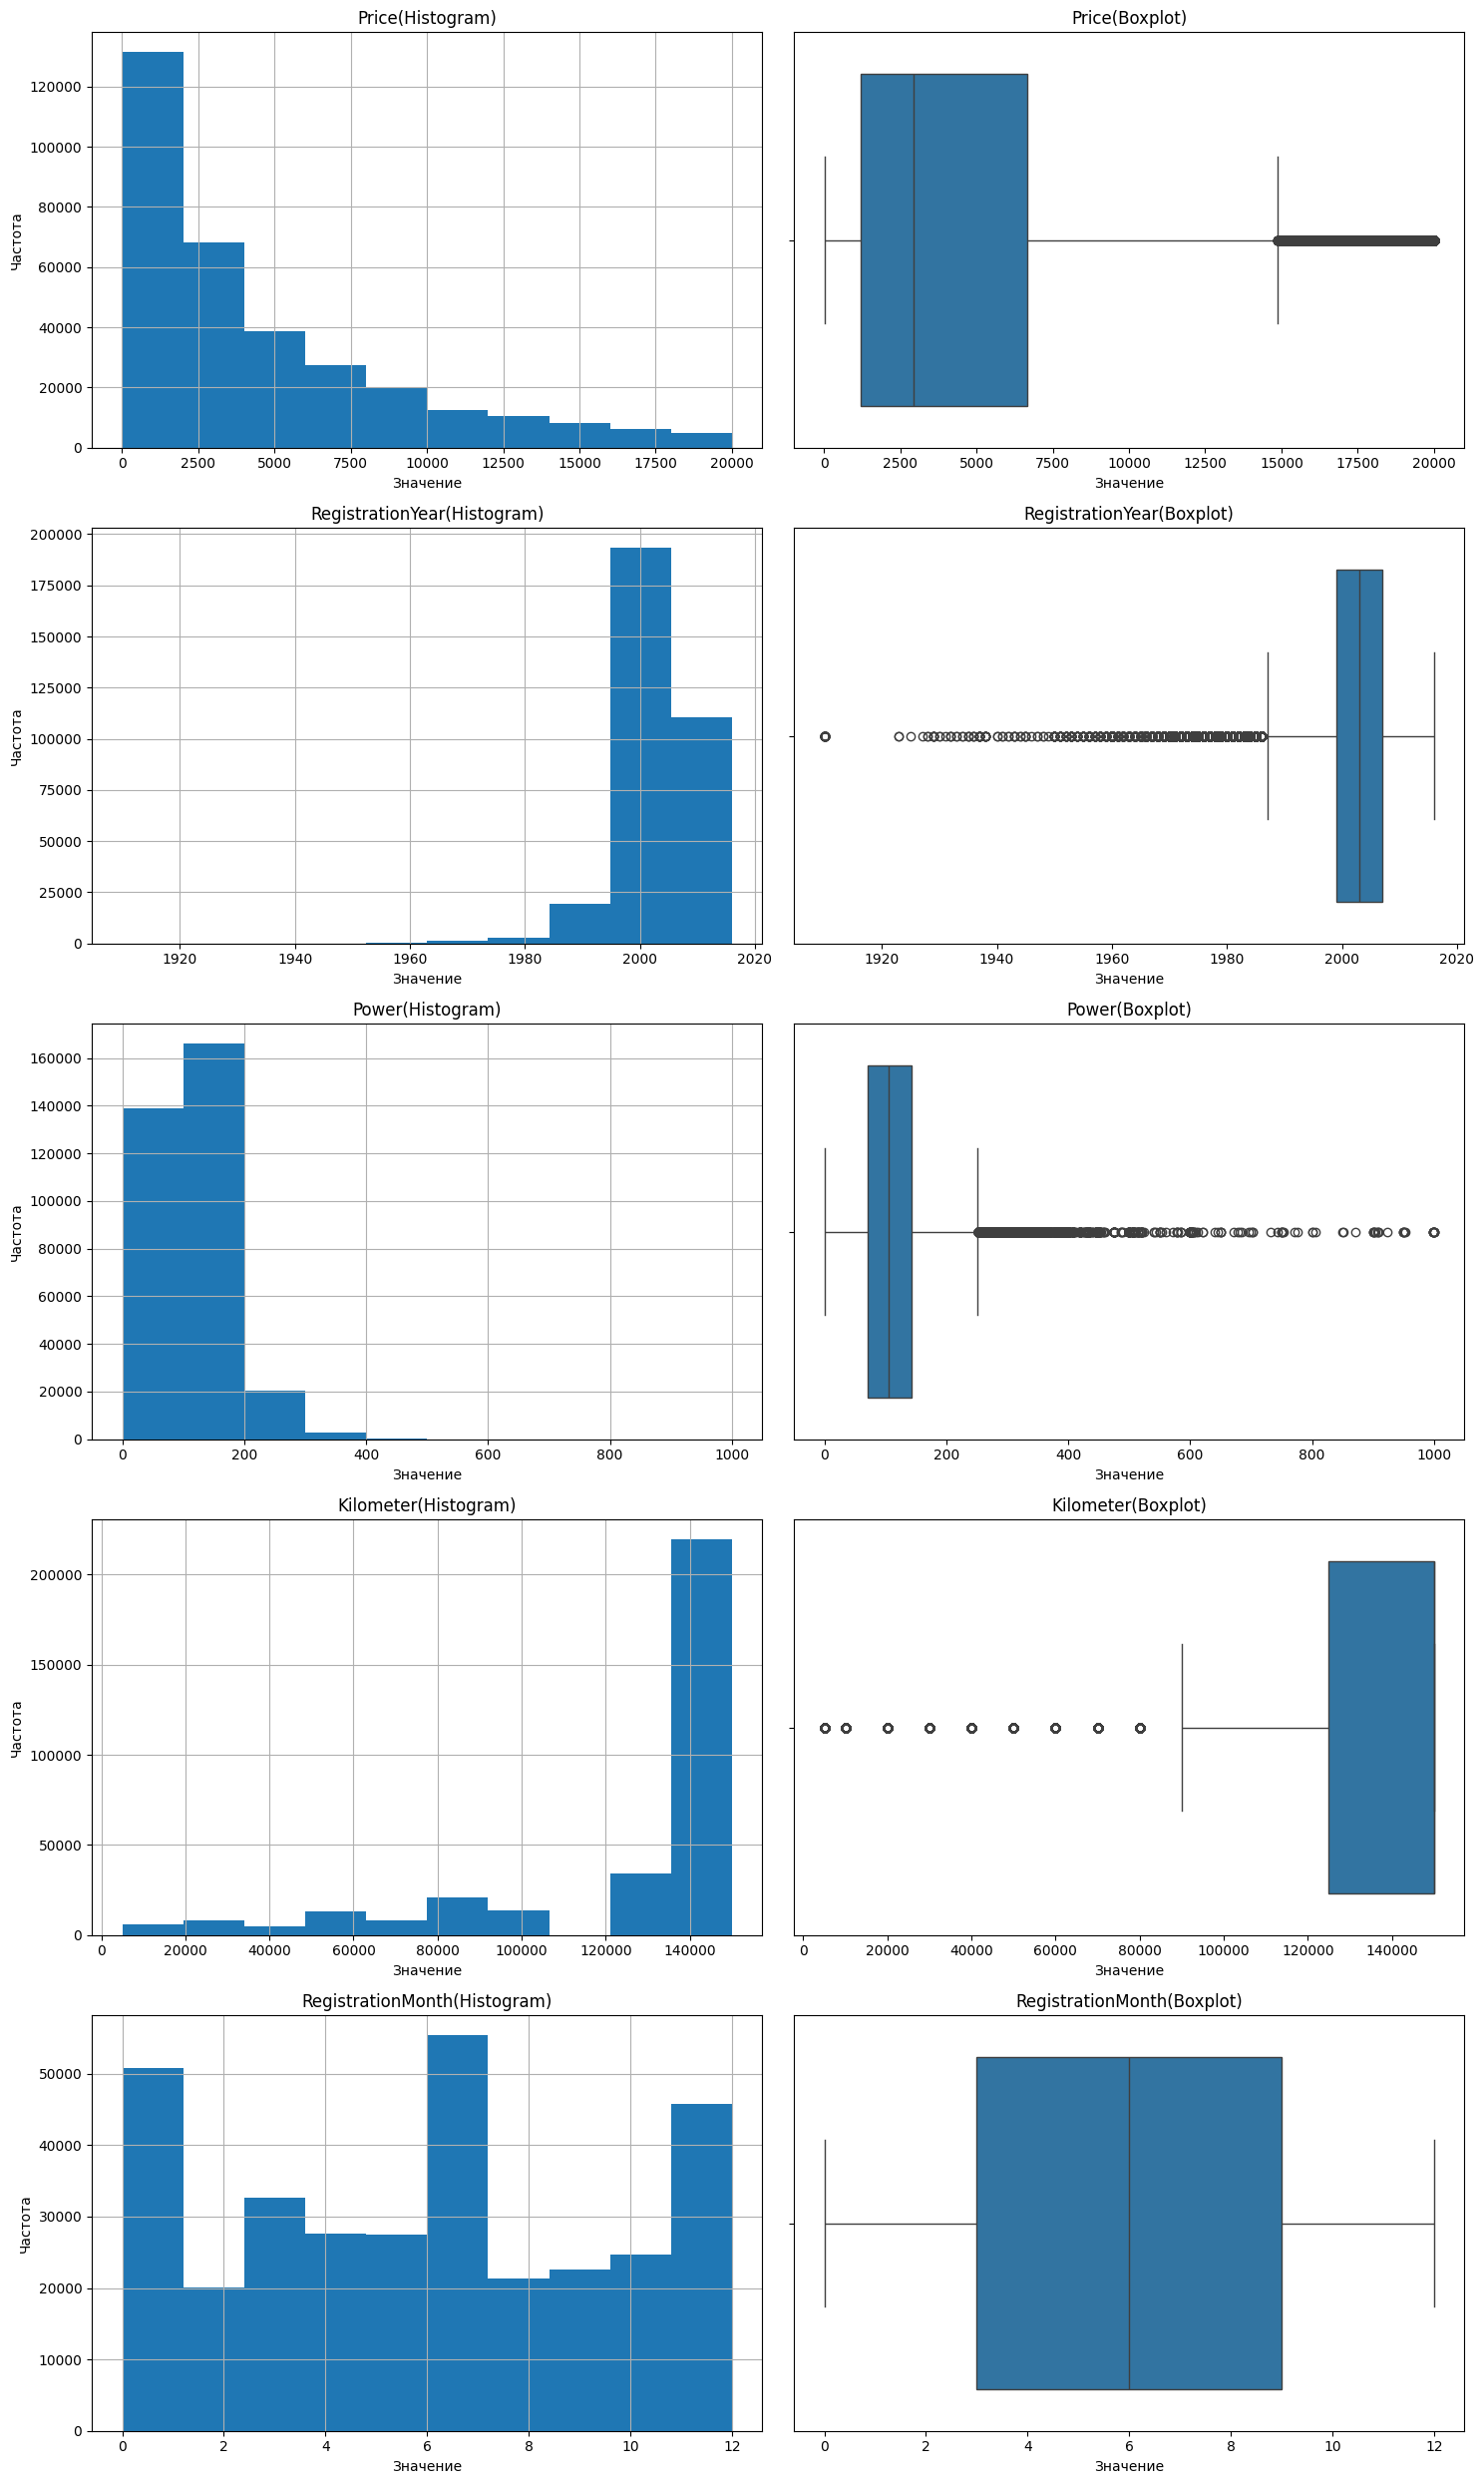

In [22]:
plot_numeric_distributions_with_boxplot(data)

Теперь необходима построить матрицу корреляции для дальнейшего анализа данных.

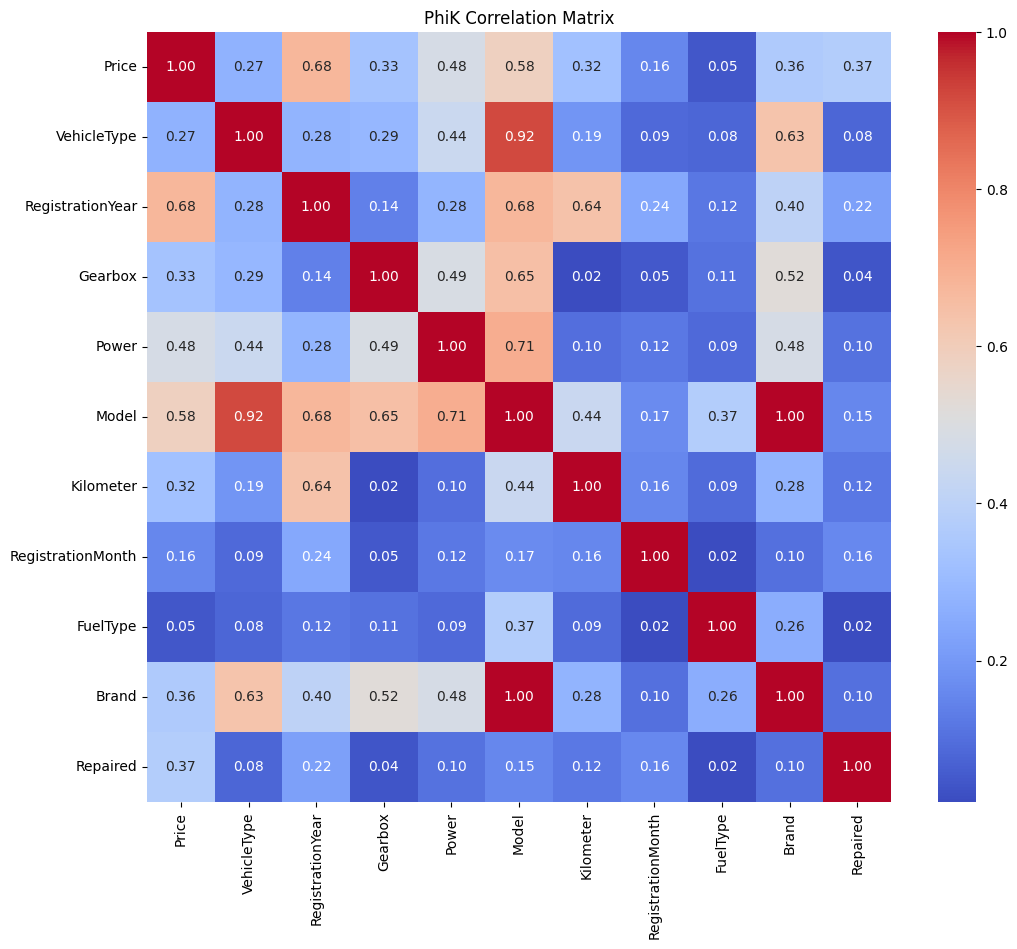

In [23]:
data = data.drop('DateCrawled', axis=1)
data = data.drop('DateCreated', axis=1)
data = data.drop('LastSeen', axis=1)

num_columns = data.select_dtypes(include=['int64']).columns.tolist()
interval_cols = ['Kilometer', 'RegistrationMonth', 'RegistrationYear']
num_columns = [col for col in num_columns if col not in interval_cols]

phik_matrix_df = data.phik_matrix(interval_cols=num_columns)

# Визуализируем матрицу PhiK
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("PhiK Correlation Matrix")
plt.show()

Удалим столбец 'Brand', что бы избежать мультиколлинеарности.

In [24]:
data = data.drop('Brand', axis=1)
#data = data.drop('VehicleType', axis=1)

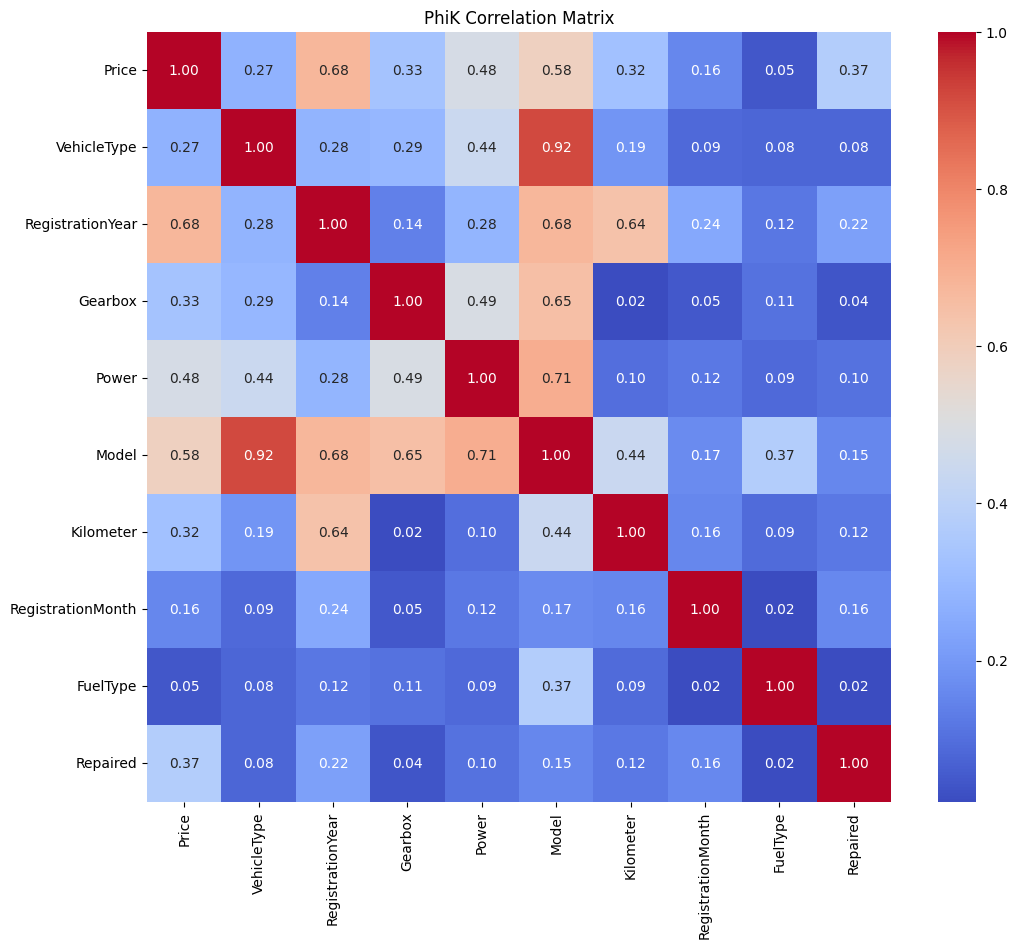

In [25]:
num_columns = data.select_dtypes(include=['int64']).columns.tolist()
interval_cols = ['Kilometer', 'RegistrationMonth', 'RegistrationYear']
num_columns = [col for col in num_columns if col not in interval_cols]

phik_matrix_df = data.phik_matrix(interval_cols=num_columns)

# Визуализируем матрицу PhiK
plt.figure(figsize=(12, 10))
sns.heatmap(phik_matrix_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("PhiK Correlation Matrix")
plt.show()

In [26]:
data = data.drop_duplicates().reset_index(drop=True)

Проведена прдобработка даных, удалены дубликаты, приведены к нужному формату. Убрали мультиколлинеарность.

## Обучение моделей

In [27]:
RANDOM_STATE = 42
TEST_SIZE = 0.25

In [28]:
ohe_columns = ['Gearbox', 'Model', 'FuelType', 'VehicleType']
ord_columns = ['Repaired']
num_columns = ['RegistrationYear', 'RegistrationMonth', 'Power', 'Kilometer']

In [29]:
y = data['Price']
X = data.drop(['Price'], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=TEST_SIZE,
        random_state=RANDOM_STATE
)

In [30]:
# Пайплайн для Binary Encoding
binary_pipe = Pipeline([
    ('imputer_binary', SimpleImputer(strategy='most_frequent')), # Заполнение пропусков
    ('binary', BinaryEncoder())  # Binary Encoding
])

# Пайплайн для Ordinal Encoding
repaired_categories = [['yes', 'no']]
ord_pipe = Pipeline([
    ('imputer_ord', SimpleImputer(strategy='most_frequent')), # Заполнение пропусков
    ('ord', OrdinalEncoder(categories=repaired_categories))  # Ordinal Encoding
])

# Пайплайн для численных признаков
num_pipe = Pipeline([
    ('imputer_num', SimpleImputer(strategy='mean')),  # Заполнение пропусков
    ('scaler', StandardScaler())  # Масштабирование
])

In [31]:
# ColumnTransformer
preprocessor = ColumnTransformer([
    ('binary', binary_pipe, ohe_columns),
    ('ord', ord_pipe, ord_columns),
    ('num', num_pipe, num_columns)
], remainder='passthrough')

In [32]:
# Финальный pipeline
model_pipeline_1 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

In [33]:
# Параметры для RandomizedSearchCV
param_grid_1 = [
    {
        'model': [LinearRegression()],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'model__max_depth': range(2, 15),
        'model__min_samples_split': range(2, 15),
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [34]:
randomized_search_1 = RandomizedSearchCV(
    model_pipeline_1,
    param_grid_1,
    cv = 5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

In [35]:
randomized_search_1.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('binary',
                                                                               Pipeline(steps=[('imputer_binary',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('binary',
                                                                                                BinaryEncoder())]),
                                                                               ['Gearbox',
                                                                                'Model',
                                                                                'FuelType',
                                                                                'VehicleType']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imputer_ord',
                                                                                                SimpleImpu...
                   param_distributions=[{'model': [LinearRegression()],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'model': [DecisionTreeRegressor(random_state=42)],
                                         'model__max_depth': range(2, 15),
                                         'model__min_samples_split': range(2, 15),
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [36]:
print("Best parameters found:", randomized_search_1.best_params_)
print("Best score found:", randomized_search_1.best_score_*-1)

Best parameters found: {'preprocessor__num__scaler': StandardScaler(), 'model__min_samples_split': 13, 'model__max_depth': 14, 'model': DecisionTreeRegressor(random_state=42)}
Best score found: 2017.9837685776008


Обучили модель.

In [41]:
# Еще один финальный pipeline )
model_pipeline_2 = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor())
])

In [42]:
param_grid_2 = [
    {
        'model': [LGBMRegressor(random_state=RANDOM_STATE)],
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': range(4, 8),
        'model__num_leaves': [20, 30, 40],
        'preprocessor__num__scaler': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'model': [CatBoostRegressor(random_state=RANDOM_STATE, verbose=0)], # verbose=0 для отключения вывода
        'model__iterations': [100, 200, 300],
        'model__depth': range(4, 8),
        'model__l2_leaf_reg': [3, 5, 7],
    }
]

In [43]:
randomized_search_2 = RandomizedSearchCV(
    model_pipeline_2,
    param_grid_2,
    cv = 5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

In [44]:
randomized_search_2.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 387
[LightGBM] [Info] Number of data points in the train set: 226881, number of used features: 22
[LightGBM] [Info] Start training from score 4618.226978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('binary',
                                                                               Pipeline(steps=[('imputer_binary',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('binary',
                                                                                                BinaryEncoder())]),
                                                                               ['Gearbox',
                                                                                'Model',
                                                                                'FuelType',
                                                                                'VehicleType']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('imputer_ord',
                                                                                                SimpleImpu...
                                         'model__n_estimators': [100, 200, 300],
                                         'model__num_leaves': [20, 30, 40],
                                         'preprocessor__num__scaler': [StandardScaler(),
                                                                       MinMaxScaler(),
                                                                       'passthrough']},
                                        {'model': [<catboost.core.CatBoostRegressor object at 0x7fa2c5ea4190>],
                                         'model__depth': range(4, 8),
                                         'model__iterations': [100, 200, 300],
                                         'model__l2_leaf_reg': [3, 5, 7]}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [45]:
print("Best parameters found:", randomized_search_2.best_params_)
print("Best score found:", randomized_search_2.best_score_*-1)

Best parameters found: {'preprocessor__num__scaler': MinMaxScaler(), 'model__num_leaves': 40, 'model__n_estimators': 200, 'model__max_depth': 7, 'model': LGBMRegressor(random_state=42)}
Best score found: 1773.7329592465398


Обучили несколько моделей, бустинг справился лучше.

In [46]:
cv_results_1 = pd.DataFrame(randomized_search_1.cv_results_)

In [47]:
metrics_1 = cv_results_1[
    ["param_model", "mean_test_score", "mean_fit_time", "mean_score_time"]
].sort_values("mean_test_score", ascending=False)

metrics_1.columns = ["Model", "RMSE (CV)", "Fit Time (s)", "Predict Time (s)"]

In [48]:
cv_results_2 = pd.DataFrame(randomized_search_2.cv_results_)

In [49]:
metrics_2 = cv_results_2[
    ["param_model", "mean_test_score", "mean_fit_time", "mean_score_time"]
].sort_values("mean_test_score", ascending=False)

metrics_2.columns = ["Model", "RMSE (CV)", "Fit Time (s)", "Predict Time (s)"]

## Анализ моделей

In [52]:
pd.set_option('display.max_columns', None)  # Показывать все столбцы
pd.set_option('display.max_rows', None) # Показывать все строки
pd.set_option('display.width', None) # Автоподбор ширины
pd.set_option('display.max_colwidth', None) # Полный текст в ячейках

In [53]:
display(metrics_1)

,Model,RMSE (CV),Fit Time (s),Predict Time (s)
8,DecisionTreeRegressor(random_state=42),-2017.983769,3.117802,0.227705
1,DecisionTreeRegressor(random_state=42),-2042.091898,3.162635,0.167727
0,DecisionTreeRegressor(random_state=42),-2053.369496,3.321733,0.159466
3,DecisionTreeRegressor(random_state=42),-2055.940720,3.159747,0.175463
2,DecisionTreeRegressor(random_state=42),-2064.033218,2.776112,0.164373
4,DecisionTreeRegressor(random_state=42),-2074.462414,2.810326,0.171681
9,DecisionTreeRegressor(random_state=42),-2098.451683,2.526811,0.155252
6,DecisionTreeRegressor(random_state=42),-2100.227530,2.741665,0.183514
5,DecisionTreeRegressor(random_state=42),-2948.851111,1.945695,0.165064
7,DecisionTreeRegressor(random_state=42),-2948.851111,1.927992,0.165625


In [54]:
display(metrics_2)

,Model,RMSE (CV),Fit Time (s),Predict Time (s)
3,LGBMRegressor(random_state=42),-1773.732959,7.332923,1.192605
8,LGBMRegressor(random_state=42),-1807.784891,7.231687,1.140501
7,LGBMRegressor(random_state=42),-1837.266714,7.055456,1.048717
9,LGBMRegressor(random_state=42),-1878.257750,8.108218,1.312576
1,LGBMRegressor(random_state=42),-1879.719780,8.813967,1.305076
2,LGBMRegressor(random_state=42),-1914.057972,5.005427,0.599004
5,LGBMRegressor(random_state=42),-1923.876602,6.521115,0.965801
4,LGBMRegressor(random_state=42),-1927.144554,4.441304,0.794077
6,<catboost.core.CatBoostRegressor object at 0x7fa2c5ea4190>,-1961.306299,20.462683,0.231135
0,<catboost.core.CatBoostRegressor object at 0x7fa2c5ea4190>,-2257.546425,7.492211,0.169920


In [55]:
print("Best parameters found:", randomized_search_2.best_params_)

Best parameters found: {'preprocessor__num__scaler': MinMaxScaler(), 'model__num_leaves': 40, 'model__n_estimators': 200, 'model__max_depth': 7, 'model': LGBMRegressor(random_state=42)}


In [56]:
model_final = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(max_depth=7, n_estimators=200, num_leaves=40, random_state=42))
])

In [57]:
%%timeit
model_final.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044147 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 226881, number of used features: 22
[LightGBM] [Info] Start training from score 4618.226978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043826 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 226881, number of used features: 22
[LightGBM] [Info] Start training from score 4618.226978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.050653 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 226881, number of used features: 22
[LightGBM] [Info] Start training from score 4618.226978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044541 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 226881, number of used features: 22
[LightGBM] [Info] Start training from score 4618.226978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 226881, number of used features: 22
[LightGBM] [Info] Start training from score 4618.226978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045473 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 226881, number of used features: 22
[LightGBM] [Info] Start training from score 4618.226978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043610 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 226881, number of used features: 22
[LightGBM] [Info] Start training from score 4618.226978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.043423 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 397
[LightGBM] [Info] Number of data points in the train set: 226881, number of used features: 22
[LightGBM] [Info] Start training from score 4618.226978
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

In [58]:
%%timeit
predict_final = model_final.predict(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11

1.28 s ± 51.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
print("Best parameters found:", randomized_search_1.best_params_)
print("Best score found:", randomized_search_1.best_score_*-1)
print("Best parameters found:", randomized_search_2.best_params_)
print("Best score found:", randomized_search_2.best_score_*-1)

Best parameters found: {'preprocessor__num__scaler': StandardScaler(), 'model__min_samples_split': 13, 'model__max_depth': 14, 'model': DecisionTreeRegressor(random_state=42)}
Best score found: 2017.9837685776008
Best parameters found: {'preprocessor__num__scaler': MinMaxScaler(), 'model__num_leaves': 40, 'model__n_estimators': 200, 'model__max_depth': 7, 'model': LGBMRegressor(random_state=42)}
Best score found: 1773.7329592465398


Была проведена предобработка данных, удалены не нужные признаки. Сделаны пайплайны.
Лучшая модель это - LGBMRegressor(max_depth=7, n_estimators=200, num_leaves=40) с метрикой RMSE 1773.73.